# Mapping and unsupervised clustering analysis for NI tests (Part 1)

### Requirements and dependencies

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator


# Graphics settings
xDim = 4
yDim = 2

### Specimen informations + Results path

In [2]:
# Sample 1
sampleNames = ['Ni_SiC']
file_paths = [Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Dataset\Ni_SiC\MTS_example1_25x25.xls")]
sheet_name = 'Sample'

# Sample 2
sampleNames = ['HSS-Steel_Carbides']
file_paths = [Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Dataset\HSS_Steel_Carbides\MTS_example1_25x25_flower.xls")]
sheet_name = 'Sample'

# Sample 3
# sampleNames = ['Al6061_T6_Al2O3']
# file_paths = [Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Dataset\Al6061_T6_Al2O3\MTS_example1_25x25_flower.xls")]
# sheet_name = 'Sample'

# Result directory
result_dir = Path(r"C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Results")


### Loading dataset and make mechanical properties dataframe

In [3]:
# Import data from Excel files
data_frames = []
for file_path in file_paths:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    data_frames.append(df)
data = pd.concat(data_frames, ignore_index=True)

# Merge first row (containing units) with the header
data.columns = [f"{col}_{unit}" if unit else col for col, unit in zip(data.columns, data.iloc[0])]
data = data.drop(index=0).reset_index(drop=True)
data = data.apply(pd.to_numeric, errors='ignore')

# Replace empty strings with NaN
data.replace("", np.nan, inplace=True)

# Remove colums Markers and Index Integer
data.drop(columns=[col for col in data.columns if 'Markers_nan' in col or 'Index_Integer' in col], inplace=True)

print(data.head())

# Save as a .csv file
data.to_csv(result_dir / 'imported_data.csv', index=False)
print(f"Data saved to {result_dir / 'imported_data.csv'}")

   X Position_µm  Y Position_µm  MODULUS_GPa  HARDNESS_GPa
0              0              0      268.522        23.307
1              2              0      224.329         8.073
2              4              0      249.184         7.273
3              6              0      274.592         6.630
4              8              0      287.293         5.951
Data saved to C:\Users\dmercier\OneDrive - ANSYS, Inc\Documents\GitHub\Indentation2025\Atelier1_ML-Clustering\Results\imported_data.csv


C:\Users\dmercier\AppData\Local\Temp\ipykernel_4252\2725171850.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  data = data.apply(pd.to_numeric, errors='ignore')


### Mapping analysis

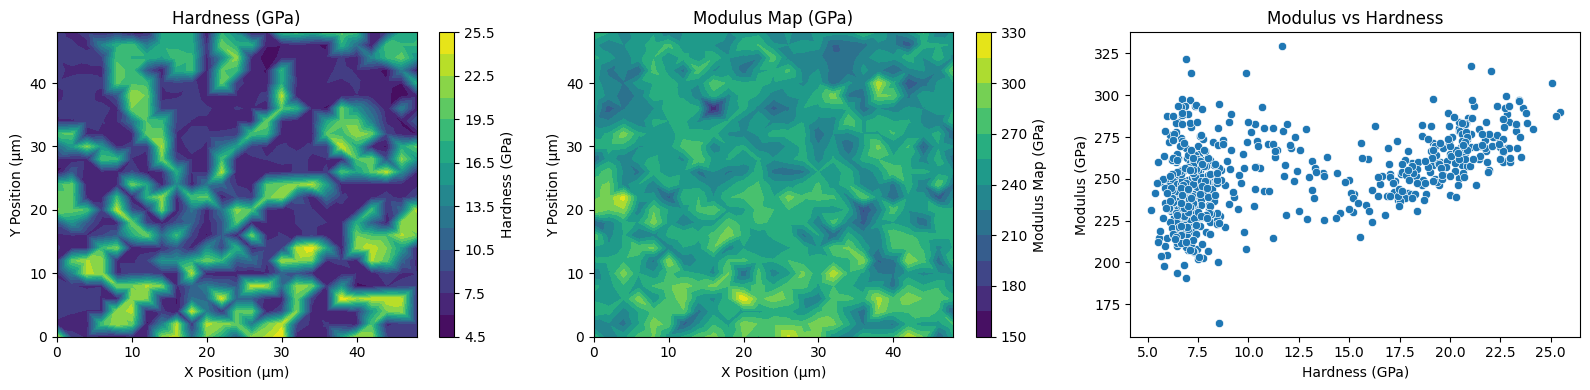

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mo

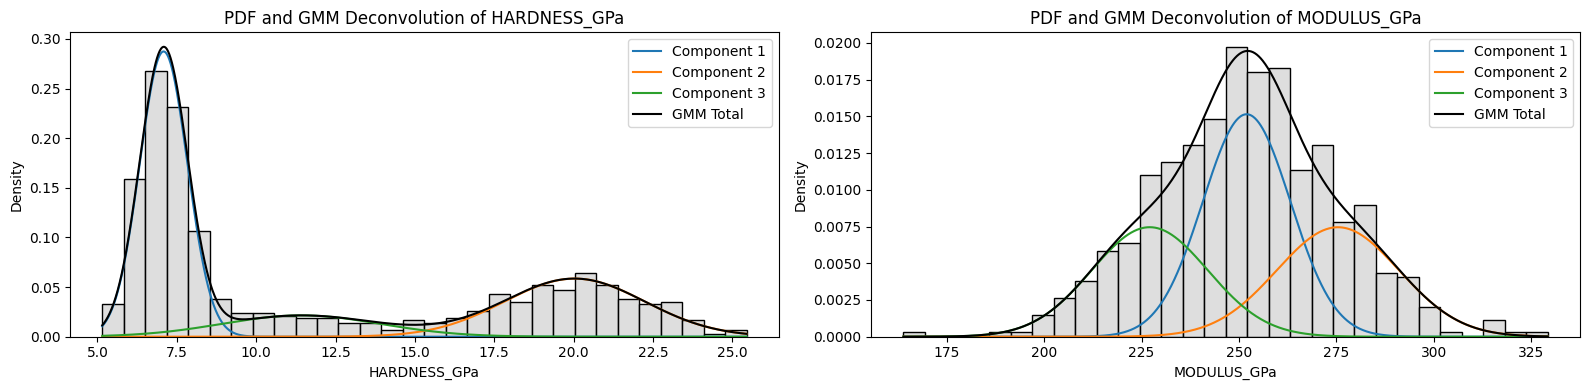

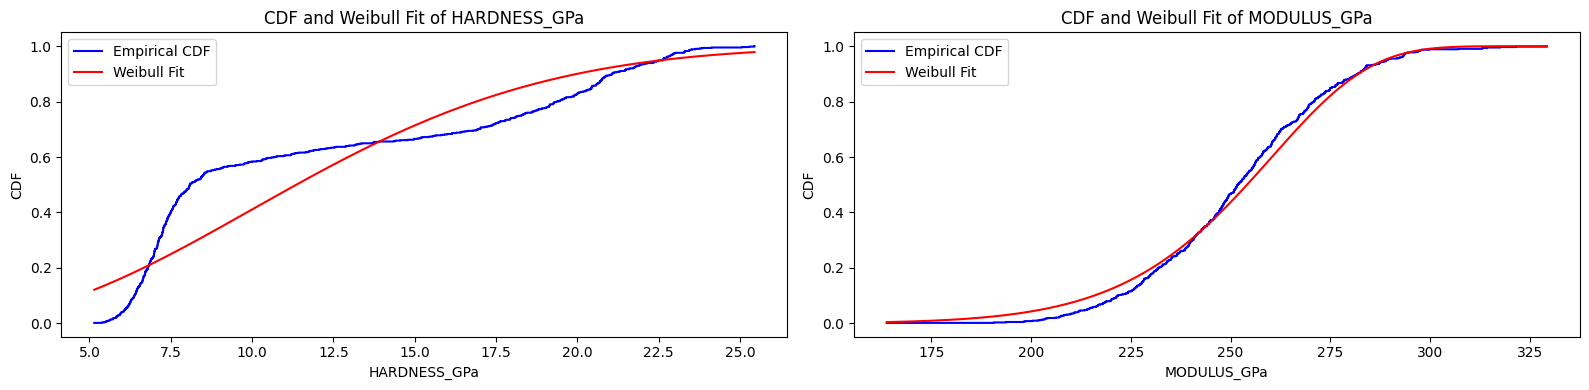

In [4]:
def plot_map(x, y, z, title, xlabel, ylabel, ax, cmap='viridis', save_path=None):
    # Filter out non-finite values
    mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
    x, y, z = x[mask], y[mask], z[mask]
    
    # Use the provided axis for plotting
    contour = ax.tricontourf(x, y, z, levels=14, cmap=cmap)
    cbar = plt.colorbar(contour, ax=ax)  # Add colorbar to the axis
    cbar.set_label(title)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path)

# Create a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(4*xDim, 2*yDim))

# Plot Hardness map
plot_map(data['X Position_µm'], data['Y Position_µm'], data['HARDNESS_GPa'], 
         title='Hardness (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         ax=axes[0])  # Pass the first subplot axis

# Plot Modulus map
plot_map(data['X Position_µm'], data['Y Position_µm'], data['MODULUS_GPa'], 
         title='Modulus Map (GPa)', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
         ax=axes[1])  # Pass the second subplot axis

# Plot Modulus vs Hardness
sns.scatterplot(y='MODULUS_GPa', x='HARDNESS_GPa', data=data, ax=axes[2])  # Pass the third subplot axis
axes[2].set_title('Modulus vs Hardness')
axes[2].set_ylabel('Modulus (GPa)')
axes[2].set_xlabel('Hardness (GPa)')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('combined_plots.png')
plt.show()

# Updated function to plot on a specific axis
def plot_pdf_with_deconvolution_on_axis(data, column, n_components, ax):
    # Plot histogram
    sns.histplot(data[column].dropna(), bins=30, kde=False, stat='density', color='lightgray', edgecolor='black', ax=ax)
    
    # Fit Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data[[column]].dropna())
    
    # Generate x values for plotting the GMM components
    x = np.linspace(data[column].min(), data[column].max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    responsibilities = gmm.predict_proba(x)
    pdf = np.exp(logprob)
    
    # Plot GMM components
    for i in range(n_components):
        ax.plot(x, responsibilities[:, i] * pdf, label=f'Component {i+1}')
    
    ax.plot(x, pdf, '-k', label='GMM Total')
    ax.set_title(f'PDF and GMM Deconvolution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.legend()

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(4*xDim, 2*yDim))

n_componentsVal = 3  # Adjust based on expected number of phases

# Plot PDF and GMM Deconvolution for Hardness
plot_pdf_with_deconvolution_on_axis(data, 'HARDNESS_GPa', n_components=n_componentsVal, ax=axes[0])

# Plot PDF and GMM Deconvolution for Modulus
plot_pdf_with_deconvolution_on_axis(data, 'MODULUS_GPa', n_components=n_componentsVal, ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('pdf_gmm_deconvolution.png')
plt.show()

def plot_cdf_with_weibull_fit_on_axis(data, column, ax):
    # Sort data and compute CDF
    sorted_data = np.sort(data[column].dropna())
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Plot empirical CDF
    ax.step(sorted_data, cdf, where='post', label='Empirical CDF', color='blue')
    
    # Fit Weibull distribution
    from scipy.stats import weibull_min
    params = weibull_min.fit(sorted_data, floc=0)
    x = np.linspace(sorted_data.min(), sorted_data.max(), 1000)
    weibull_cdf = weibull_min.cdf(x, *params)
    
    # Plot Weibull fit
    ax.plot(x, weibull_cdf, 'r-', label='Weibull Fit')
    
    ax.set_title(f'CDF and Weibull Fit of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('CDF')
    ax.legend()

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(4*xDim, 2*yDim))

# Plot CDF and Weibull fit for Hardness
plot_cdf_with_weibull_fit_on_axis(data, 'HARDNESS_GPa', ax=axes[0])
# Plot CDF and Weibull fit for Modulus
plot_cdf_with_weibull_fit_on_axis(data, 'MODULUS_GPa', ax=axes[1])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('cdf_weibull_fit.png')
plt.show()



### Matrix correlation analysis

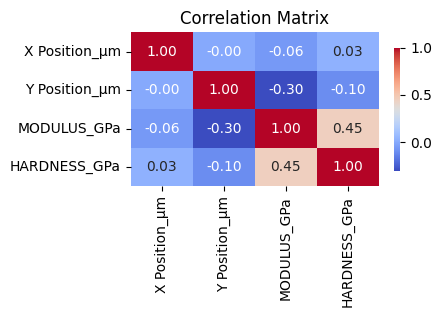

In [5]:
# Plot matrix correlation
plt.figure(figsize=(xDim, yDim))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

### Clustering analysis - Number of clusters estimation

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\

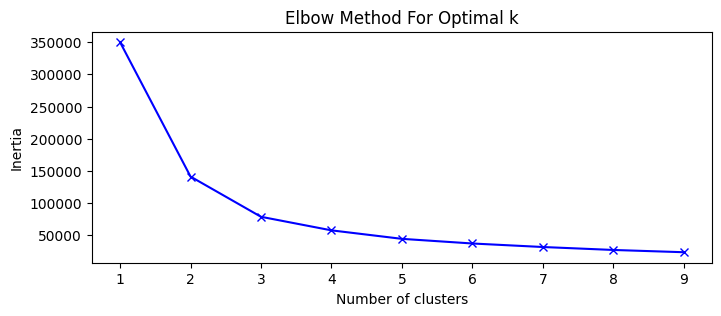

Optimal number of clusters: 3


In [6]:
# Cluster the data using KMeans, or GMM...
method = 'KMeans'
#method = 'GMM'
# ... DBSCAN ?

if method == 'KMeans':
    # Determine optimal number of clusters using Elbow Method
    inertia = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna())
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Method
    plt.figure(figsize=(2*xDim, 1.5*yDim))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.savefig('elbow_method.png')
    plt.show()

    # Find the optimal number of clusters using KneeLocator
    knee_locator = KneeLocator(K, inertia, curve="convex", direction="decreasing")
    optimal_k = knee_locator.knee

elif method == 'GMM':
    # Determine optimal number of clusters using BIC
    bics = []
    K = range(1, 10)
    for k in K:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna())
        bics.append(gmm.bic(data[['HARDNESS_GPa', 'MODULUS_GPa']].dropna()))

    # Plot the BIC
    plt.figure(figsize=(2*xDim, 1.5*yDim))
    plt.plot(K, bics, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('BIC')
    plt.title('BIC For Optimal k')
    plt.savefig('bic_method.png')
    plt.show()

    # Find the optimal number of clusters using KneeLocator
    knee_locator = KneeLocator(K, bics, curve="convex", direction="increasing")
    optimal_k = knee_locator.knee
    
print(f"Optimal number of clusters: {optimal_k}")
#optimal_k = 3  # Manually set for demonstration purposes

# Define colors for clusters
colors = sns.color_palette('tab10', n_colors=optimal_k)

### Clustering analysis - K-means clustering

   HARDNESS_GPa  MODULUS_GPa  Cluster
0        23.307      268.522        0
1         8.073      224.329        2
2         7.273      249.184        1
3         6.630      274.592        0
4         5.951      287.293        0


c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


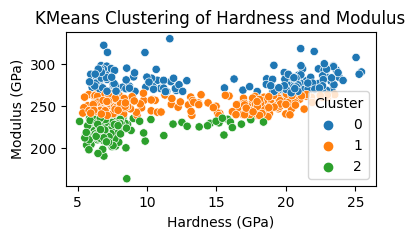

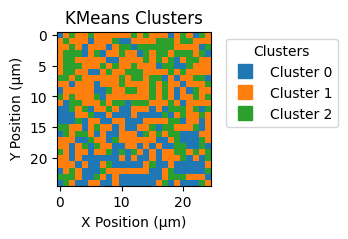

        HARDNESS_GPa                          MODULUS_GPa                      \
                mean       std    min     max        mean        std      min   
Cluster                                                                         
0          15.916960  6.582996  5.867  25.445  279.460764  11.829717  264.625   
1          11.598565  5.563095  5.380  23.520  251.278469   7.584072  236.720   
2           7.907220  2.638029  5.151  18.389  222.936855  11.326279  163.865   

                 Count  
             max count  
Cluster                 
0        329.307   174  
1        265.346   292  
2        237.432   159  
Cluster 0: 174 points, 27.84%
Cluster 1: 292 points, 46.72%
Cluster 2: 159 points, 25.44%
NaN or empty data: 0 points, 0.00%
Total ratio: 100.00%


In [7]:
if method == 'KMeans':
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
elif method == 'GMM':
    kmeans = GaussianMixture(n_components=optimal_k, random_state=42)

data = data.dropna(subset=['HARDNESS_GPa', 'MODULUS_GPa']).reset_index(drop=True)

if method == 'KMeans':
    data['Cluster'] = kmeans.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa']])
elif method == 'GMM':
    data['Cluster'] = kmeans.fit(data[['HARDNESS_GPa', 'MODULUS_GPa']]).predict(data[['HARDNESS_GPa', 'MODULUS_GPa']])

data['Cluster'] = data['Cluster'].astype(int)
print(data[['HARDNESS_GPa', 'MODULUS_GPa', 'Cluster']].head())

# Plot clustered data using colors defined above
plt.figure(figsize=(xDim, yDim))
sns.scatterplot(x='HARDNESS_GPa', y='MODULUS_GPa', hue='Cluster', palette=colors, data=data)
plt.title('KMeans Clustering of Hardness and Modulus')
plt.xlabel('Hardness (GPa)')
plt.ylabel('Modulus (GPa)')
plt.legend(title='Cluster')
plt.savefig('kmeans_clusters.png')
plt.show()

# Function to create a grid and plot square pixels
def plot_pixel_map(x, y, z, title, xlabel, ylabel, cluster_colors, save_path=None):
    # Create a pivot table to structure data into a grid
    grid_data = pd.DataFrame({'X': x, 'Y': y, 'Cluster': z})
    pivot = grid_data.pivot(index='Y', columns='X', values='Cluster')
    
    # Sort the grid to ensure proper alignment
    pivot = pivot.sort_index(ascending=False)  # Y-axis should be inverted for plotting
    
    # Create a colormap for clusters
    unique_clusters = np.unique(z)
    cluster_cmap = [cluster_colors[cluster] for cluster in unique_clusters]
    cmap = plt.matplotlib.colors.ListedColormap(cluster_cmap)
    
    # Plot the grid as square pixels
    plt.figure(figsize=(xDim, yDim))
    plt.imshow(pivot, cmap=cmap, aspect='equal', interpolation='none')  # Square pixels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Add a legend for clusters
    handles = [plt.Line2D([0], [0], marker='s', color=color, linestyle='', markersize=10, label=f'Cluster {cluster}')
               for cluster, color in zip(unique_clusters, cluster_cmap)]
    plt.legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Save with tight layout to include the legend
    plt.show()

# Create a colormap for clusters
cmap = {i: colors[i] for i in range(optimal_k)}
data['Cluster_Color'] = data['Cluster'].map(cmap)

# Plot clusters on spatial map with square pixels
plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], data['Cluster'], 
               title='KMeans Clusters', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
               cluster_colors=cmap, save_path='spatial_clusters_square_pixels.png')

# Print cluster statistics
cluster_stats = data.groupby('Cluster').agg({
    'HARDNESS_GPa': ['mean', 'std', 'min', 'max'],
    'MODULUS_GPa': ['mean', 'std', 'min', 'max'],
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

print(cluster_stats)

# Print clusters ratio in %
total_points = len(data)
for cluster in range(optimal_k):
    count = len(data[data['Cluster'] == cluster])
    ratio = (count / total_points) * 100
    print(f"Cluster {cluster}: {count} points, {ratio:.2f}%")
# Print NaN or empty data ratio in %
nan_count = data[['HARDNESS_GPa', 'MODULUS_GPa']].isna().any(axis=1).sum()
nan_ratio = (nan_count / (total_points + nan_count)) * 100
print(f"NaN or empty data: {nan_count} points, {nan_ratio:.2f}%")
# Check that all % make 100%
total_ratio = sum((len(data[data['Cluster'] == cluster]) / total_points) * 100 for cluster in range(optimal_k)) + nan_ratio
print(f"Total ratio: {total_ratio:.2f}%")


### All plots

c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
C:\Users\dmercier\AppData\Local\Temp\ipykernel_4252\2073133692.py:63: UserWarning: 

The `vertical` parameter is deprecated; assigning data to `y`.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(data['MODULUS_GPa'], ax=axes[1, 1], fil

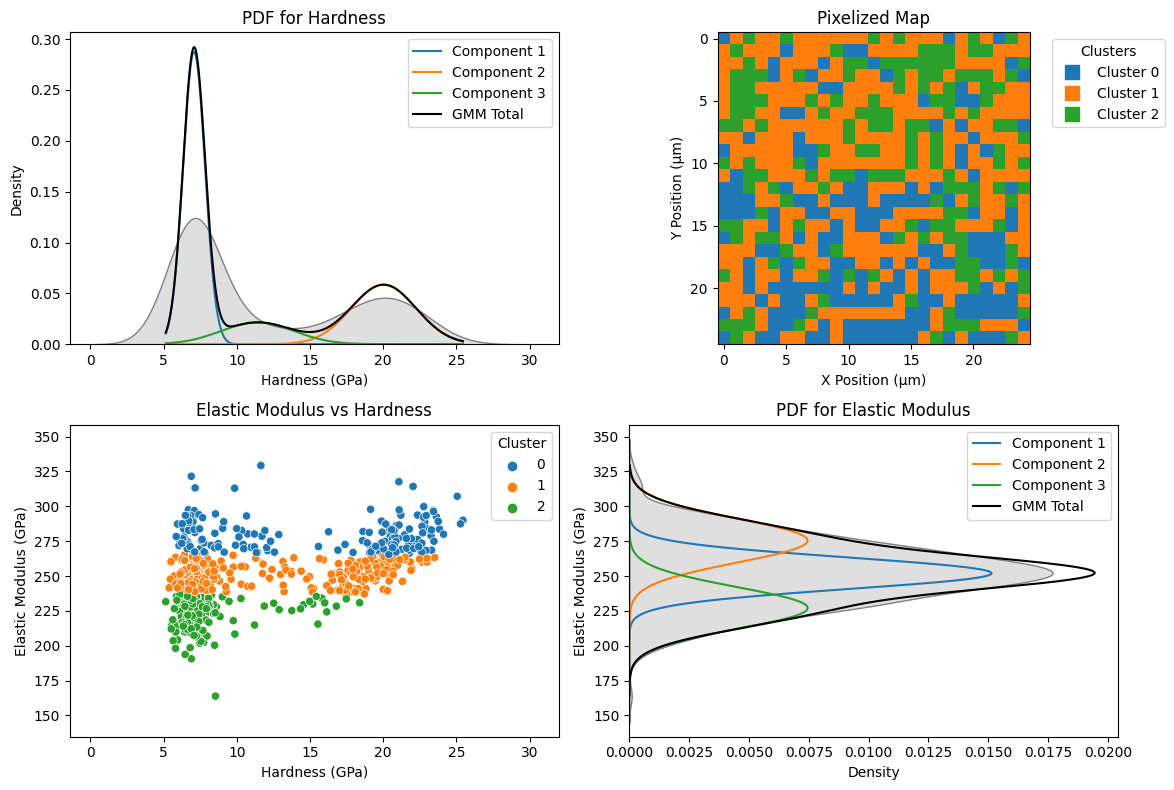

In [8]:
# Define the number of clusters
optimal_k = len(data['Cluster'].unique())

# Define colors for clusters
colors = sns.color_palette('tab10', n_colors=optimal_k)
cluster_cmap = ListedColormap(colors)

# Pivot data for pixelized map (handle duplicates by aggregating with pivot_table)
grid_data = data.pivot_table(
    index='Y Position_µm',
    columns='X Position_µm',
    values='Cluster',
    aggfunc='mean'  # You can use 'mean', 'median', or another aggregation function
)
grid_data = grid_data.sort_index(ascending=False)  # Ensure proper orientation

# Create the 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(3*xDim, 4*yDim))

# Top Left: PDF for Hardness
sns.kdeplot(data['HARDNESS_GPa'], ax=axes[0, 0], fill=True, color='gray')
axes[0, 0].set_title('PDF for Hardness')
axes[0, 0].set_xlabel('Hardness (GPa)')
axes[0, 0].set_ylabel('Density')
# Add Deconvolution with peaks with same colors as corresponding clusters
n_componentsVal = optimal_k  # Use the optimal number of clusters determined earlier
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=n_componentsVal, random_state=0)
gmm.fit(data[['HARDNESS_GPa']].dropna())
x = np.linspace(data['HARDNESS_GPa'].min(), data['HARDNESS_GPa'].max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
for i in range(n_componentsVal):
    axes[0, 0].plot(x, responsibilities[:, i] * pdf, label=f'Component {i+1}', color=colors[i])
axes[0, 0].plot(x, pdf, '-k', label='GMM Total')
axes[0, 0].legend()

# Top Right: Pixelized Map
im = axes[0, 1].imshow(grid_data, cmap=cluster_cmap, aspect='equal', interpolation='none')
axes[0, 1].set_title('Pixelized Map')
axes[0, 1].set_xlabel('X Position (µm)')
axes[0, 1].set_ylabel('Y Position (µm)')

# Create discrete legend handles for clusters
unique_clusters = np.unique(grid_data[~np.isnan(grid_data)])  # Exclude NaN values
handles = [
    plt.Line2D(
        [0], [0], 
        marker='s', 
        color=cluster_cmap(cluster / len(unique_clusters)), 
        linestyle='', 
        markersize=10, 
        label=f'Cluster {int(cluster)}'
    ) 
    for cluster in unique_clusters if not np.isnan(cluster)  # Ensure cluster is not NaN
]

# Add the discrete legend
axes[0, 1].legend(handles=handles, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

# Bottom Right: PDF for Elastic Modulus rotated 90°
sns.kdeplot(data['MODULUS_GPa'], ax=axes[1, 1], fill=True, color='gray', vertical=True)
axes[1, 1].set_title('PDF for Elastic Modulus')
axes[1, 1].set_xlabel('Density')
axes[1, 1].set_ylabel('Elastic Modulus (GPa)')
# Add Deconvolution with peaks with same colors as corresponding clusters
gmm = GaussianMixture(n_components=n_componentsVal, random_state=0)
gmm.fit(data[['MODULUS_GPa']].dropna())
x = np.linspace(data['MODULUS_GPa'].min(), data['MODULUS_GPa'].max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)
responsibilities = gmm.predict_proba(x)
pdf = np.exp(logprob)
for i in range(n_componentsVal):
    axes[1, 1].plot(responsibilities[:, i] * pdf, x, label=f'Component {i+1}', color=colors[i])
axes[1, 1].plot(pdf, x, '-k', label='GMM Total')
axes[1, 1].legend()

# Bottom Left: Elastic Modulus vs Hardness with same axis scale than PDFs plots
sns.scatterplot(x='HARDNESS_GPa', y='MODULUS_GPa', hue='Cluster', palette=colors, data=data, ax=axes[1, 0])
axes[1, 0].set_title('Elastic Modulus vs Hardness')
axes[1, 0].set_xlabel('Hardness (GPa)')
axes[1, 0].set_ylabel('Elastic Modulus (GPa)')
axes[1, 0].set_xlim(axes[0, 0].get_xlim())
axes[1, 0].set_ylim(axes[1, 1].get_ylim())
axes[1, 0].legend(title='Cluster')

# Adjust layout
plt.tight_layout()
plt.show()

### Principle component analysis (PCA)

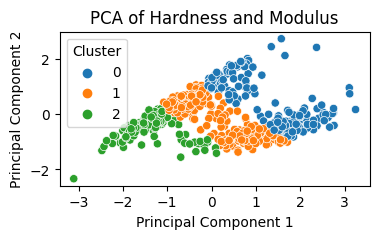

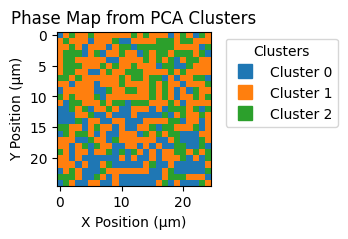

In [9]:
# Investigate Principle Component Analysis (PCA)
# scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Standardize the data
features = ['HARDNESS_GPa', 'MODULUS_GPa']
x = StandardScaler().fit_transform(data[features])
# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['Cluster'] = data['Cluster'].values
# Plot PCA results
plt.figure(figsize=(xDim, yDim))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette=colors, data=pc_df)
plt.title('PCA of Hardness and Modulus')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.savefig('pca_clusters.png')
plt.show()

# Plot the corresponding phase map
plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], data['Cluster'], 
               title='Phase Map from PCA Clusters', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
               cluster_colors=cmap, save_path='pca_spatial_clusters_square_pixels.png') 

### Agglomerative clustering

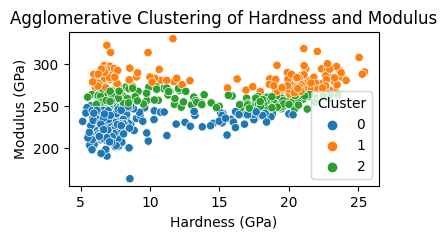

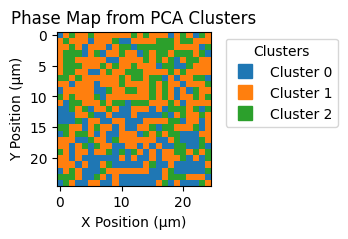

In [10]:
# Agglomerative Clustering
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=optimal_k)
data['Agglo_Cluster'] = agglo.fit_predict(data[['HARDNESS_GPa', 'MODULUS_GPa']])
# Plot Agglomerative Clustering results
plt.figure(figsize=(xDim, yDim))
sns.scatterplot(x='HARDNESS_GPa', y='MODULUS_GPa', hue='Agglo_Cluster', palette=colors, data=data)
plt.title('Agglomerative Clustering of Hardness and Modulus')
plt.xlabel('Hardness (GPa)')
plt.ylabel('Modulus (GPa)')
plt.legend(title='Cluster')
plt.savefig('agglo_clusters.png')
plt.show()

# Plot the corresponding phase map
plot_pixel_map(data['X Position_µm'], data['Y Position_µm'], data['Cluster'], 
               title='Phase Map from PCA Clusters', xlabel='X Position (µm)', ylabel='Y Position (µm)', 
               cluster_colors=cmap, save_path='pca_spatial_clusters_square_pixels.png') 


### LLM for clustering

In [11]:
import time
from openai import AzureOpenAI
import os

# Retry mechanism
def call_openai_with_retry(client, model, messages, retries=3, delay=60):
    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=messages
            )
            return response
        except Exception as e:
            if "429" in str(e):
                print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                raise e
    raise Exception("Max retries exceeded.")

# Set Azure OpenAI endpoint and API key as environment variables
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://ansys-matbu-hackathon.openai.azure.com/"
os.environ["AZURE_OPENAI_API_KEY"] = "32bfdf19c6b04c5ea33f44eb8f4510e9"

client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2024-12-01-preview"
)

# Read csv file
import json
csv_file_path = result_dir / 'imported_data.csv'
df = pd.read_csv(csv_file_path)
json_data = df.to_dict(orient='records')

# Prepare prompts
system_prompt = "You are a data scientist skilled in machine learning and data analysis, and visualization. Provide insights and code examples for data-related tasks."
# Send only the first 5 records or a subset of the JSON data
user_prompt = f"Analyze the following csv file and do a clustering analysis. Generate a full python script using a .csv file: {json.dumps(json_data[:500])}"

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt}
]

response = call_openai_with_retry(client, model='gpt-4.1', messages=messages)

# Extract full response content
full_response = response.choices[0].message.content
# Save the full response to a text file
with open(result_dir / 'openai_response.txt', 'w') as f:
    f.write(full_response)
# Print the full response
print(full_response)

Absolutely! Here is a **full example script** that loads your CSV data, applies KMeans clustering to the mechanical property columns (`MODULUS_GPa`, `HARDNESS_GPa`), visualizes the results on a scatter plot and a spatial heatmap, and outputs cluster assignments.

You can save your data to `sample.csv` (use the JSON portion to generate the CSV).

**Key steps**:

1. CSV loading, exploration, visualization.
2. Feature scaling (important for clustering).
3. KMeans clustering, optimal K suggestion using the elbow method.
4. Result visualization: cluster scatter and spatial plots.
5. Summary report.

---

```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- Step 1. Load the CSV data ---
df = pd.read_csv('sample.csv')  # Replace with your .csv path

print("Basic info:")
print(df.info())
print("\nHead of data:")
print(df.head())

# --- Step 2. Explore an

Head of the data:
    X Position_µm  Y Position_µm  MODULUS_GPa  HARDNESS_GPa
0              0              0      268.522        23.307
1              2              0      224.329         8.073
2              4              0      249.184         7.273
3              6              0      274.592         6.630
4              8              0      287.293         5.951

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X Position_µm  625 non-null    int64  
 1   Y Position_µm  625 non-null    int64  
 2   MODULUS_GPa    625 non-null    float64
 3   HARDNESS_GPa   625 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 19.7 KB
None

NaN summary:
 X Position_µm    0
Y Position_µm    0
MODULUS_GPa      0
HARDNESS_GPa     0
dtype: int64

After dropping NaN: 625 rows left.
Clusters: 2, Silhouette Score: 0.503


c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clusters: 3, Silhouette Score: 0.478
Clusters: 4, Silhouette Score: 0.467
Clusters: 5, Silhouette Score: 0.478


c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clusters: 6, Silhouette Score: 0.445


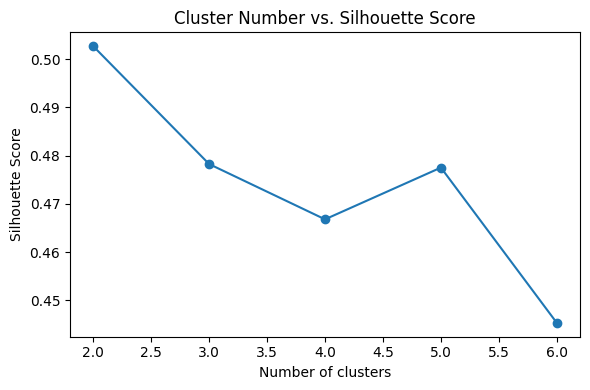


Optimal number of clusters: 2


c:\Users\dmercier\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


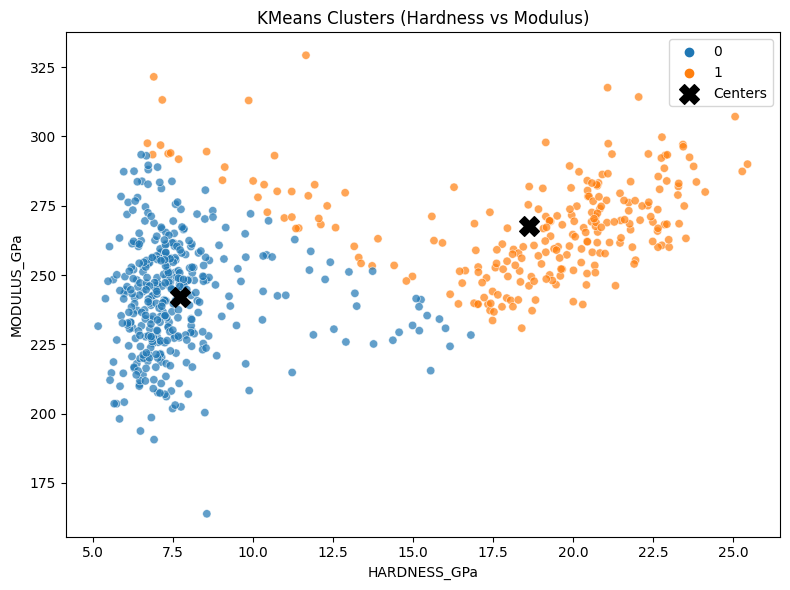


Cluster Summary Statistics:
         HARDNESS_GPa                          MODULUS_GPa                      \
                mean       std    min     max        mean        std      min   
cluster                                                                         
0           7.712506  1.994772  5.151  16.800  242.110044  19.964580  163.865   
1          18.608571  4.076456  6.691  25.445  267.856550  17.829013  230.840   

                  
             max  
cluster           
0        293.436  
1        329.307  

Clustered data saved to 'data_with_clusters.csv'.


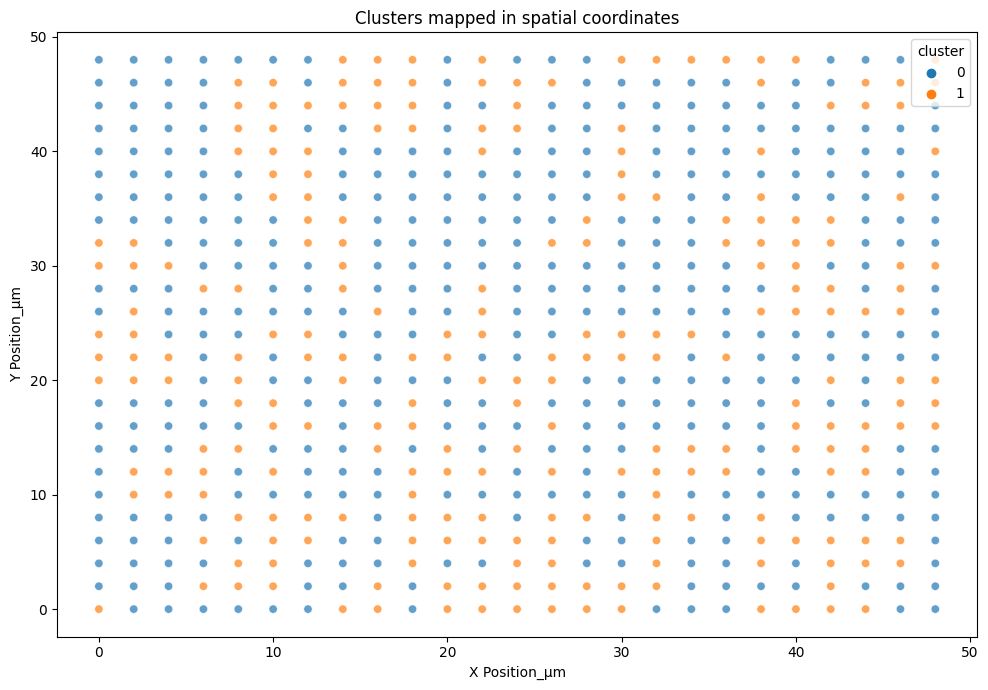

In [12]:
# Certainly! Here is a full Python script to analyze your CSV data for clustering. The script will:

# 1. **Load the data** (assuming you save it as `data.csv`).
# 2. **Clean and preprocess** (handle NaNs).
# 3. **Standardize features**.
# 4. **K-Means clustering** (with optimal cluster selection using silhouette score).
# 5. **Visualize clustering results** (scatter plot and cluster centers).
# 6. **Show summary statistics per cluster**.

# You can use this code with your CSV file.  
# **If your data is still in JSON, you can first convert it with pandas:**


# ### Main Analysis Code (`clustering_analysis.py`)

# ```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Load the data
df = pd.read_csv('Results/imported_data.csv')

# 2. Quick Exploration
print("Head of the data:\n", df.head())
print("\nData info:")
print(df.info())
print("\nNaN summary:\n", df.isna().sum())

# 3. Drop rows with NaN in features used for clustering
features = ['HARDNESS_GPa', 'MODULUS_GPa']
df_cluster = df.dropna(subset=features).copy()

print(f"\nAfter dropping NaN: {df_cluster.shape[0]} rows left.")

# 4. Standardize the features for clustering
scaler = StandardScaler()
X = scaler.fit_transform(df_cluster[features])

# 5. Determine optimal number of clusters with silhouette score
range_n_clusters = range(2, 7)
scores = []
for n in range_n_clusters:
    km = KMeans(n_clusters=n, random_state=42)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"Clusters: {n}, Silhouette Score: {score:.3f}")
    scores.append(score)

# Plot silhouette scores to choose optimal
plt.figure(figsize=(6,4))
plt.plot(range_n_clusters, scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Cluster Number vs. Silhouette Score')
plt.tight_layout()
plt.show()

optimal_clusters = range_n_clusters[np.argmax(scores)]
print(f"\nOptimal number of clusters: {optimal_clusters}")

# 6. Fit final clustering
km = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = km.fit_predict(X)
df_cluster['cluster'] = cluster_labels

# 7. Visualization
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_cluster,
    x='HARDNESS_GPa', y='MODULUS_GPa',
    hue='cluster', palette='tab10', alpha=0.7
)
# Plot cluster centers (inverse transform to original units)
centers = scaler.inverse_transform(km.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], 
    s=200, c='black', marker='X', label='Centers')
plt.legend()
plt.title('KMeans Clusters (Hardness vs Modulus)')
plt.tight_layout()
plt.show()

# 8. Cluster summary statistics
summary = df_cluster.groupby('cluster')[features].agg(['mean','std','min','max'])
print("\nCluster Summary Statistics:\n", summary)

# 9. Save clustered data for reference
df_cluster.to_csv('data_with_clusters.csv', index=False)
print("\nClustered data saved to 'data_with_clusters.csv'.")

# 10. Optionally, spatial plot
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=df_cluster,
    x='X Position_µm', y='Y Position_µm', hue='cluster', palette='tab10', alpha=0.7
)
plt.title('Clusters mapped in spatial coordinates')
plt.tight_layout()
plt.show()
# ```

# ---

# **How to run:**

# 1. Save your CSV file as `data.csv` in the same directory.
# 2. Save this script as `clustering_analysis.py`.
# 3. Run: `python clustering_analysis.py`

# **You can adjust feature selection, cluster range, or plotting as needed!**  
# Let me know if you'd like PCA or alternative clustering (DBSCAN) as well.